# <center><b>  Convulution Neural Network For Breast Cancer Image Recognition </center></b>

## <b> Introduction: </b>
Today

## <b> Data: </b>
Talk about Data

In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_score, recall_score, accuracy_score,roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import os
import cv2
import glob
import shutil


import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


In [3]:
df = pd.read_csv('C:\\Users\\logan\\Capstone\\train\\train.csv', sep=',')
print(df.shape)
df.head()

(54706, 14)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


## <b> Exploratory Data Analysis </b>
Based on the first 5 entries it can already be seen that there are missing values which could be problematic for model development. To start checking the quality of the data we will first see how many missing values are present. 

In [4]:
df.isnull().sum(axis=0)

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

This is problematic since BIRADS and density are missing about half of their entries. However, age is missing only missing 37 values which these entries could be removed or imputed and shouldn't cause too much of a problem. Next the porportions for laterality, view and site id will be visualized to get an understanding for the situations surrounding the images that are captured. 

<Axes: xlabel='view', ylabel='count'>

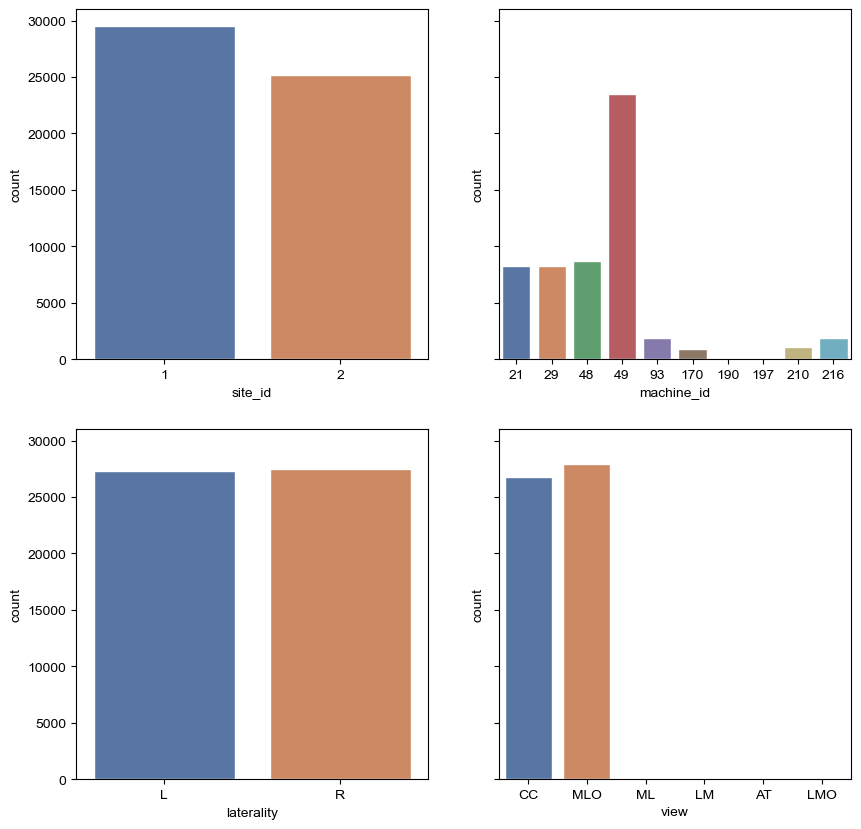

In [5]:
fig,axes=plt.subplots(nrows=2, ncols=2,  sharex=False, sharey=True,figsize=(10,10))
sns.set(style="darkgrid")
#Fig 1
sns.countplot(x="site_id", data=df,ax=axes[0,0])

#Fig 2

sns.countplot(x="machine_id", data=df,ax=axes[0,1])
#Fig 3
sns.countplot(x="laterality", data=df,ax=axes[1,0])


#Fig 4
sns.countplot(x="view", data=df,ax=axes[1,1])

In [6]:
#
print("Site ID:")
print(df['site_id'].value_counts(normalize=True))
print("Laterality:")
print(df['laterality'].value_counts(normalize=True))
print("View:")
print(df['view'].value_counts(normalize=True))

Site ID:
1    0.539593
2    0.460407
Name: site_id, dtype: float64
Laterality:
R    0.501572
L    0.498428
Name: laterality, dtype: float64
View:
MLO    0.510054
CC     0.489252
AT     0.000347
LM     0.000183
ML     0.000146
LMO    0.000018
Name: view, dtype: float64


Talk about images

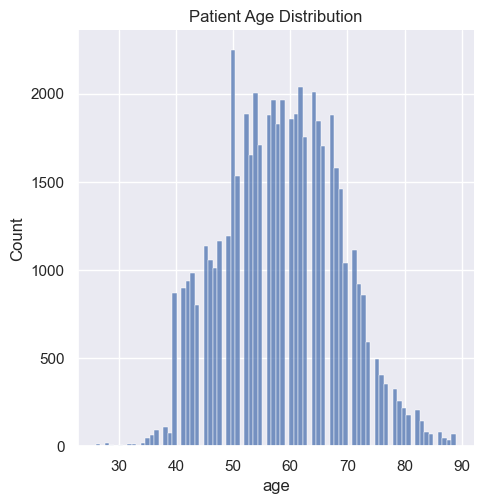

In [7]:
# Plot of ages
sns.displot(data=df, x="age").set(title='Patient Age Distribution')


In [8]:
df['age'].describe()

count    54669.000000
mean        58.543928
std         10.050884
min         26.000000
25%         51.000000
50%         59.000000
75%         66.000000
max         89.000000
Name: age, dtype: float64

Talkabout age distribution 

[Text(0.5, 1.0, 'BIRAD Score Distribution')]

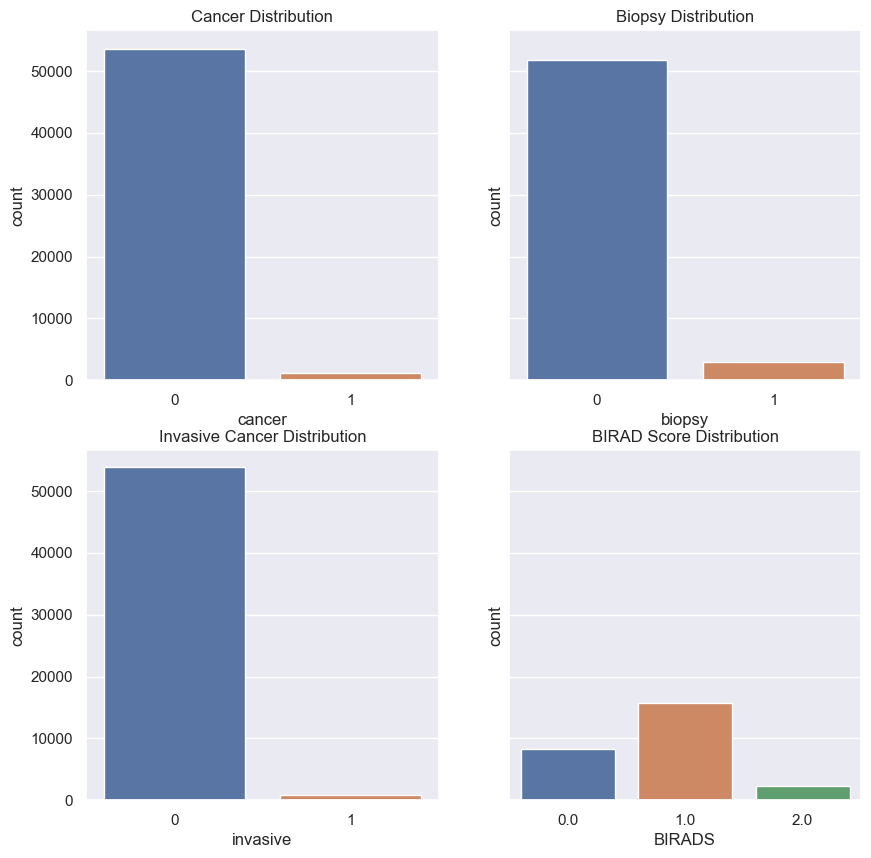

In [9]:
fig,axes=plt.subplots(nrows=2, ncols=2,  sharex=False, sharey=True,figsize=(10,10))
sns.set(style="darkgrid")
#Fig 1
sns.countplot(x="cancer", data=df,ax=axes[0,0]).set(title='Cancer Distribution')

#Fig 2

sns.countplot(x="biopsy", data=df,ax=axes[0,1]).set(title='Biopsy Distribution')
#Fig 3
sns.countplot(x="invasive", data=df,ax=axes[1,0]).set(title='Invasive Cancer Distribution')


#Fig 4
sns.countplot(x="BIRADS", data=df,ax=axes[1,1]).set(title='BIRAD Score Distribution')

In [10]:
print("Cancer:")
print(df['cancer'].value_counts(normalize=True))
print("Biopsy:")
print(df['biopsy'].value_counts(normalize=True))
print("Invasive:")
print(df['invasive'].value_counts(normalize=True))
print("BIRADS:")
print(df['BIRADS'].value_counts(normalize=True))

Cancer:
0    0.978832
1    0.021168
Name: cancer, dtype: float64
Biopsy:
0    0.945728
1    0.054272
Name: biopsy, dtype: float64
Invasive:
0    0.985047
1    0.014953
Name: invasive, dtype: float64
BIRADS:
1.0    0.600015
0.0    0.313817
2.0    0.086168
Name: BIRADS, dtype: float64


Discuss:


[Text(0.5, 1.0, 'Breast Density Distribution')]

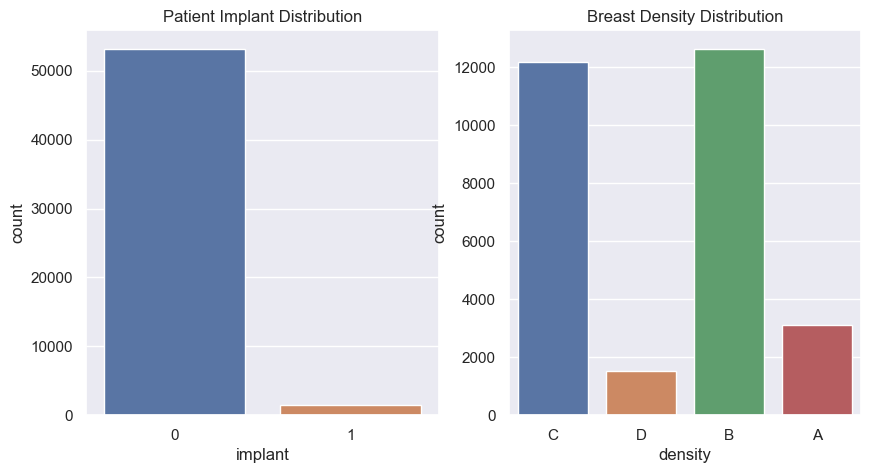

In [11]:
fig,axes=plt.subplots(nrows=1, ncols=2,figsize=(10,5))
sns.set(style="darkgrid")

# Fig 1
sns.countplot(x="implant", data=df,ax=axes[0]).set(title='Patient Implant Distribution')

# Fig 2
sns.countplot(data=df, x="density",ax=axes[1]).set(title='Breast Density Distribution')


In [12]:
print("Implant:")
print(df['implant'].value_counts(normalize=True))
print("Density:")
print(df['density'].value_counts(normalize=True))

Implant:
0    0.973001
1    0.026999
Name: implant, dtype: float64
Density:
B    0.429284
C    0.413132
A    0.105361
D    0.052223
Name: density, dtype: float64


Discuss:


[Text(0.5, 0, 'Difficult Diagnosis'),
 Text(0.5, 1.0, 'Diagnosis Difficulty Distribution')]

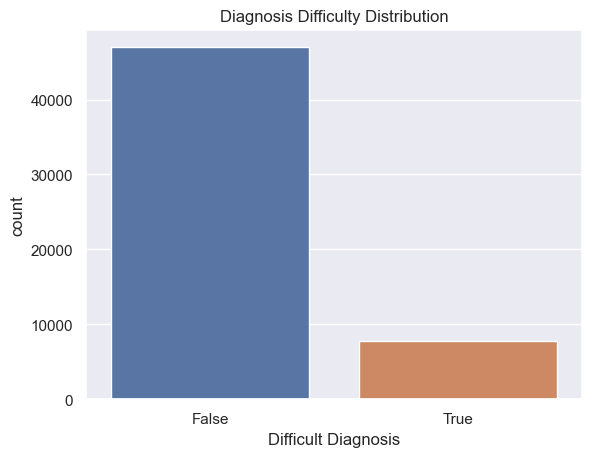

In [13]:
sns.countplot(x="difficult_negative_case", data=df).set(xlabel='Difficult Diagnosis',title='Diagnosis Difficulty Distribution')

In [14]:
df['difficult_negative_case'].value_counts(normalize=True)

False    0.859156
True     0.140844
Name: difficult_negative_case, dtype: float64

Discuss


Now we will look to see what the images look like. 

(256, 256, 3)


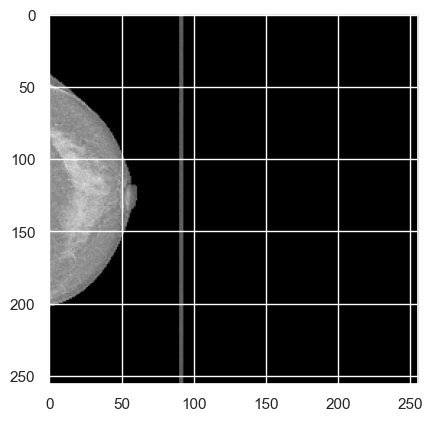

In [15]:
img = cv2.imread('C:\\Users\\logan\\Capstone\\BreastCancer\\10006_462822612.png')
plt.imshow(img, cmap = 'gray')
print(img.shape)

Talk about why CNN is best model for the problem

## <b> Feature Engineering: </b>
To start a column needs to be added to the data set creating a path for the image for each row. 

In [16]:
for i in range(len(df)):
    df.loc[i, 'path'] = 'C:\\Users\\logan\\Capstone\\BreastCancer\\'+ str(df.loc[i, 'patient_id']) + '_' + str(df.loc[i, 'image_id'])  +'.png'
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,C:\Users\logan\Capstone\BreastCancer\10006_462...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,C:\Users\logan\Capstone\BreastCancer\10006_145...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,C:\Users\logan\Capstone\BreastCancer\10006_186...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,C:\Users\logan\Capstone\BreastCancer\10006_187...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,C:\Users\logan\Capstone\BreastCancer\10011_220...


In [17]:
path=df.loc[1, 'path']
path

'C:\\Users\\logan\\Capstone\\BreastCancer\\10006_1459541791.png'

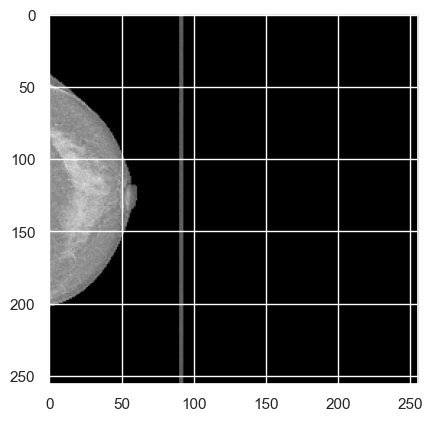

In [18]:
im = cv2.imread('C:\\Users\\logan\\Capstone\\BreastCancer\\10006_1459541791.png')
plt.imshow(img, cmap = 'gray')

This shows that the paths added are correct and direct to the correct image. 

In [19]:
train, val = train_test_split(df,test_size = 0.2,random_state = 1,stratify = df[['cancer']])


In [20]:
print("train:")
print(train.shape)
print('val:')
print(val.shape)

train:
(43764, 15)
val:
(10942, 15)


Since a CNN is going to be used the images need to be split into cancer and normal for each train and validation set. 

In [21]:
train_normal = train[train['cancer'] == 0].reset_index(drop = True)
train_cancer= train[train['cancer'] == 1].reset_index(drop = True)
val_normal= val[val['cancer'] == 0].reset_index(drop = True)
val_cancer= val[val['cancer'] == 1].reset_index(drop = True)
print(train_normal.shape)
print(train_cancer.shape)
print(val_normal.shape)
print(val_cancer.shape)

(42838, 15)
(926, 15)
(10710, 15)
(232, 15)


Discuss the split of data.

Next images from each group need to be added to folder for the model to use to train. 

In [22]:
for path in train_normal['path']:
    shutil.copy2(path, 'C:\\Users\\logan\\Capstone\\CNN\\train\\normal')
for path in train_cancer['path']:
    shutil.copy2(path, 'C:\\Users\\logan\\Capstone\\CNN\\train\\cancer')
for path in val_normal['path']:
    shutil.copy2(path, 'C:\\Users\\logan\\Capstone\\CNN\\val\\normal')
for path in val_cancer['path']:
    shutil.copy2(path, 'C:\\Users\\logan\\Capstone\\CNN\\val\\cancer')
    dst_file=os.path


In [23]:
train_normal_images = glob.glob('C:\\Users\\logan\\Capstone\\CNN\\train\\normal\\*.png')
train_cancer_images = glob.glob('C:\\Users\\logan\\Capstone\\CNN\\train\\cancer\\*.png')

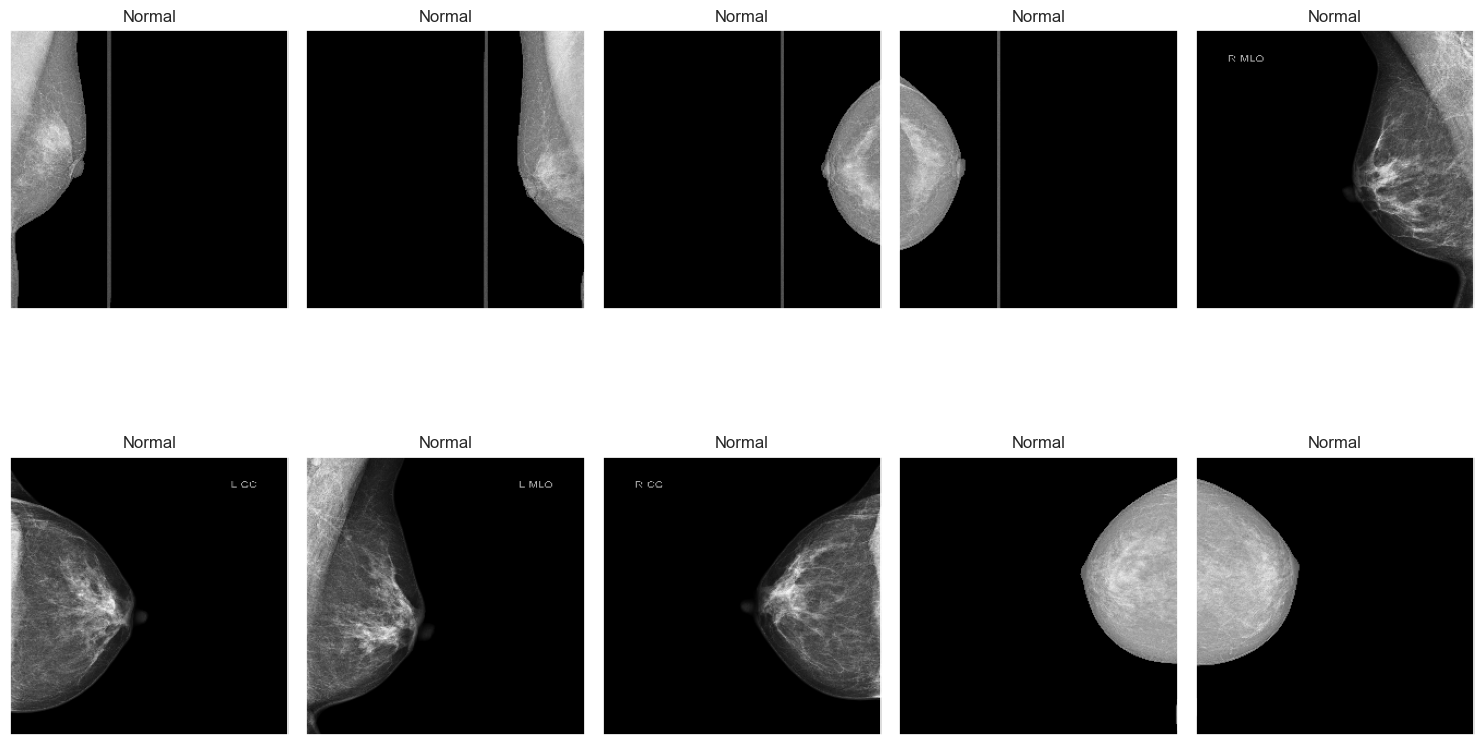

In [24]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(train_normal_images[i])
    ax.imshow(img)
    ax.set_title('Normal')
fig.tight_layout()    

plt.show()

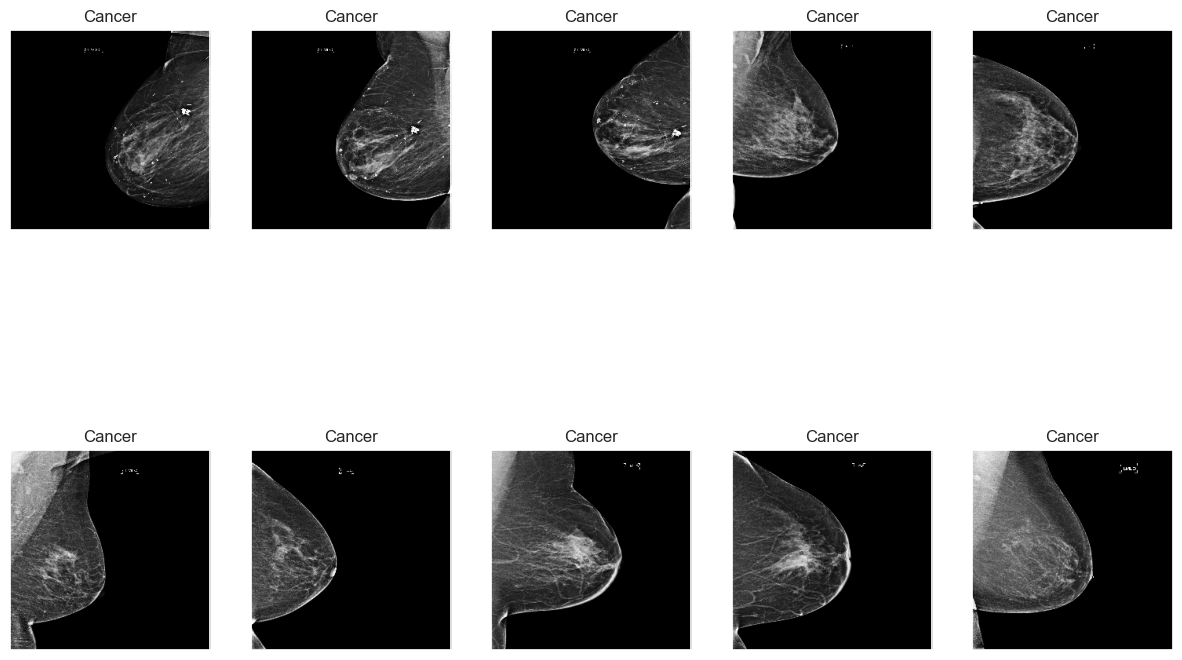

In [25]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(train_cancer_images[i])
    ax.imshow(img)
    ax.set_title('Cancer')
    
plt.show()

## <b> Model Training: </b>
Hi

In [26]:
train_datagen = ImageDataGenerator(rescale = 1./255.)
val_datagen = ImageDataGenerator(rescale = 1./255.)

In [27]:
train_path = 'C:\\Users\\logan\\Capstone\\CNN\\train'
val_path = 'C:\\Users\\logan\\Capstone\\CNN\\val'

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary'
)

Found 43764 images belonging to 2 classes.
Found 10942 images belonging to 2 classes.


In [28]:
model_b = ResNet50V2(weights = 'imagenet', input_shape = (256, 256, 3), include_top = False)

for layer in model_b.layers:
    layer.trainable = False
    
model = Sequential()
model.add(model_b)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 262,401
Non-trainable params: 23,564,800
______________________________________

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 12, callbacks = callback)

Epoch 1/12
20/20 [==============================] - 345s 18s/step - loss: 0.2117 - accuracy: 0.9828 - val_loss: 0.1111 - val_accuracy: 0.9788
Epoch 2/12
20/20 [==============================] - 375s 20s/step - loss: 0.1619 - accuracy: 0.9750 - val_loss: 0.1424 - val_accuracy: 0.9788
Epoch 3/12
20/20 [==============================] - 394s 21s/step - loss: 0.1649 - accuracy: 0.9734 - val_loss: 0.1152 - val_accuracy: 0.9788
Epoch 4/12
20/20 [==============================] - 390s 20s/step - loss: 0.1264 - accuracy: 0.9750 - val_loss: 0.1084 - val_accuracy: 0.9788
Epoch 5/12
20/20 [==============================] - 389s 20s/step - loss: 0.0981 - accuracy: 0.9812 - val_loss: 0.1099 - val_accuracy: 0.9788
Epoch 6/12
20/20 [==============================] - 385s 20s/step - loss: 0.1303 - accuracy: 0.9766 - val_loss: 0.1056 - val_accuracy: 0.9788
Epoch 7/12
20/20 [==============================] - 387s 20s/step - loss: 0.0951 - accuracy: 0.9812 - val_loss: 0.1161 - val_accuracy: 0.9788
Epoch 

In [71]:
model.save('pred_model.h5')

In [72]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## <b> Model Evaluation: </b>
First a visualization to see how the performance improved after each epoch. 

Text(0, 0.5, 'loss')

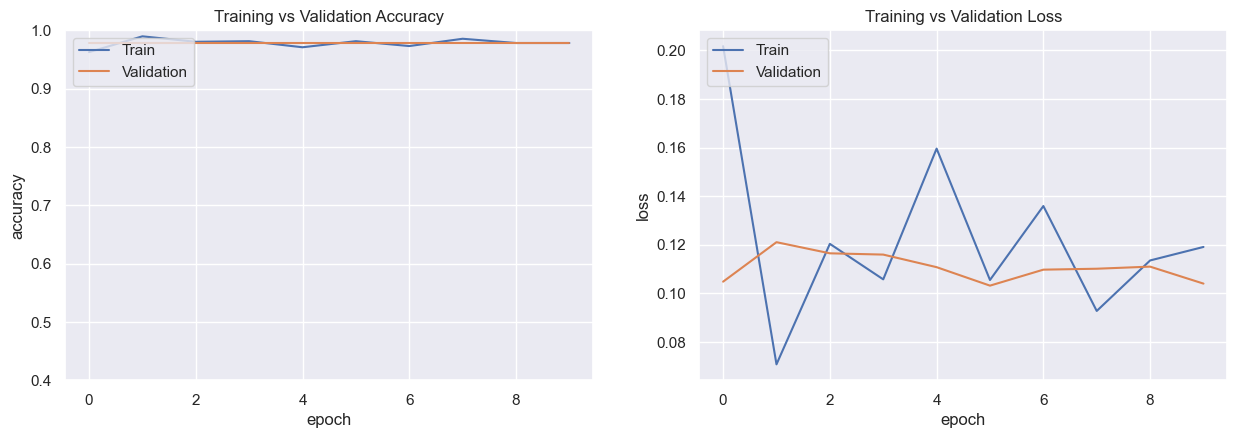

In [88]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

The accuracy for the training and validation seemed to be consistent at about 97% which is too be expected due to the low percentage of cancer images. For the loss for the training it seemed to be be inconsistent varying after each epoch. However, ultimately it did seem to decrease. Importantly the validation loss continued to improve having an initial increase followed by a consistent decrease in the loss score. To get a better idea of the performance of the model a confusion matrix will be obtained by using the model on the validation data. 

In [76]:
model = load_model('C:\\Users\\logan\\Capstone\\pred_model.h5')

In [77]:
performance= model.predict(validation_generator)

684/684 [==============================] - 1380s 2s/step


In [79]:
y_pred = []
for prob in performance:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [80]:
pd.Series(y_pred).value_counts()

1    10942
dtype: int64

In [81]:
y_true = validation_generator.classes

In [84]:
cm = confusion_matrix(y_true, y_pred)

Text(47.25, 0.5, 'Truth')

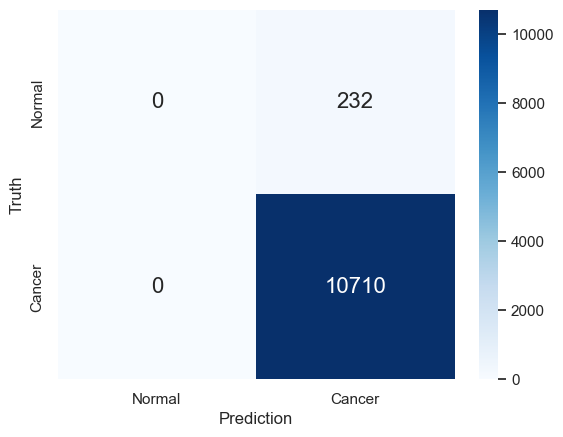

In [85]:
class_names = ['Normal', 'Cancer']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

In [86]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       232
           1       0.98      1.00      0.99     10710

    accuracy                           0.98     10942
   macro avg       0.49      0.50      0.49     10942
weighted avg       0.96      0.98      0.97     10942



C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
